# Pyger Documentation

#### This documentation is implemented as an ipython notebook. Please download and run this notebook and explore this functionality to get a feel for how Pyger works. Please visit [http://ipython.org/notebook.html](http://ipython.org/notebook.html) for more information on Python notebooks.

Pyger is a tool for calculating allowed hot dwell times and associated cooldown times given spacecraft thermal constraints. More specifically Pyger:

 - Uses a Monte-Carlo approach to sample a realistic ensemble of simulation starting temperatures.

 - Generates both typically achievable (50%) and best-case (90%) hot dwell times.

 - Generates typically achievable cooldown times for individual MSIDs.

 - Includes all xija-based thermal models and the `pline` mode for available hot time (not cooldown time).

 - Hot constraints implemented as Python classes derived from a base ConstraintModel class.

 - Cooldown constraints implemented as Python Numpy Arrays

 - Outputs data to pickle files for later use.

Due to the large number of constraints and the potential complexity of their interaction, it is suggested that dwell time characteristics be calculated on an individual model by model basis and superimposed while post processing the data rather than including multiple models in the initial dwell time simulations. Although the latter is possible in the current Pyger framework, it limits one’s ability to draw insights from the data.



## Initial Setup and Command Line Usage

Some basic functionality can be performed directly from the command line. This is useful for generating the inputs required for all Pyger calculations, as well as testing to ensure Pyger is functioning correctly. At this time, more detailed analyses are best performed either within the ipython environment or via Python scripting.

The command line usage section cannot be executed directly from this ipython notebook. Please execute these commands using a terminal in your working directory. You will at least need to execute the `pyger make` command to generate the required simulation inputs, as described below, which will be needed later for the pyger scripting section.

Pyger is available from within the Ska runtime environment. To initialize the environment, at the command line enter:

`% source /proj/sot/ska/bin/ska_envs.csh`

After this confirm that the pyger tool is available by asking for help:

    % pyger --help
    usage: pyger [-h] {make,sim} ...
    
    optional arguments:
      -h, --help  show this help message and exit

    Required sub-command (use exactly one):
      {make,sim}  Use "pyger <sub_command> --help" for help on sub-commands
        make      Make simulation inputs
        sim       Simulate constraints

Lastly, this notebook should be run from the directory where the `sim_inputs.pkl` file is stored.

### Make simulation inputs

In order to generate realistic set of dwell times pyger requires a realistic set of starting conditions that are appropriate to the time of the simulation. Since there is no longer a single "best-case" starting temperature as there was for a 1-DOF TEPHIN model, pyger does this in the following fashion:

 - Starting condition is a vector of temperatures (e.g. TEPHIN, TCYLAFT6, ...) or accumulated warm time

 - Need an ensemble of starting conditions based on realistic observing profiles leading up to start of simulation

 - Use a random sampling of actual profiles from the last year to generate propagated conditions:

  - Choose actual observation dwells to set conditions just prior to simulation start (maneuvers are   filtered out of initial sampling set)

  - A default minimum dwell time of 1ksec is used to generate sampling set of final dwells for propagation profiles

  - For each profile start propagation 3 days before simulation start time

  - Start with as-observed temperatures at the beginning of the 3 day profile

  - Use thermal model to propagate temperatures during 3 day profile at simulation start date/time so simulation starts with representative conditions

  - This works for any thermal model including PSMC with variable CCD-count dependence

Actually generating the simulation inputs file is done with the command `pyger make`. First look at the available options:

    % pyger make --help
    usage: pyger make [-h] [--sim-file SIM_FILE] [--start START] [--stop STOP] [--n-days N_DAYS]

    optional arguments:
      -h, --help           
                Show this help message and exit
      --sim-file SIM_FILE      
                Output file (default = sim_inputs.pkl)
      --start START       
                Sim input start time (default = Now - 1 year)
      --stop STOP         
                Sim input stop time (default = Now - 10 days)
      --n-days N_DAYS      
                Number of days to propagate prior to perigee exit (default = 3)
      --min-dwell-sec      
                Minimum number of seconds to use as a propagation ending dwell (default = 1000)
      --max-dwell-num      
                Maximum number of sample dwells to save (default = 300)

Now run it, which takes about two minutes using the recommended default settings:

    % pyger make
    
      Finding suitable propagation ending dwells between:
        Start:2015:114:18:54:05.696
        Stop:2016:114:18:54:04.696
      Limiting number of sample dwells to 300
      Found 300 suitable propagation ending dwells at least 1000 seconds long.
      Assembling simulation propagation data for model: fwdblkhd
        Fetching state values: pitch
        Fetching telemetry for: 4rt700t
      Assembling simulation propagation data for model: aca
        Fetching state values: pitch
        Fetching telemetry for: aacccdpt
      Assembling simulation propagation data for model: tank
        Fetching state values: pitch
        Fetching telemetry for: pftank2t
      Assembling simulation propagation data for model: psmc
        Fetching state values: pitch, ccd_count, fep_count, clocking, vid_board, simpos
        Fetching telemetry for: 1pdeaat
      Assembling simulation propagation data for model: acisfp
        Fetching state values: pitch, ccd_count, fep_count, clocking, vid_board, simpos
        Fetching telemetry for: fptemp_11
      Assembling simulation propagation data for model: tcylaft6
        Fetching state values: pitch
        Fetching telemetry for: tcylaft6
      Assembling simulation propagation data for model: dpa
        Fetching state values: pitch, ccd_count, fep_count, clocking, vid_board, simpos
        Fetching telemetry for: 1dpamzt
      Assembling simulation propagation data for model: dea
        Fetching state values: pitch, ccd_count, fep_count, clocking, vid_board, simpos
        Fetching telemetry for: 1deamzt
      Writing simulation inputs to sim_inputs.pkl


Note that the `--start` and `--stop` parameters can be specified in any valid `DateTime` format. Occasionally you will receive an out of bounds error at this step. If you receive this error, just reissue the `pyger make` command. This is a related to the random manner in which dwells are chosen.


### Run Constraint Simulation

From the command line, constraint simulation and plot generation is done with `pyger sim`. First look at the available options:

    %pyger sim --help
    usage: pyger sim [-h] [--start START] [--n-sim N_SIM] [--dt DT]
                     [--max-tcylaft6 MAX_TCYLAFT6] [--max-1pdeaat MAX_1PDEAAT]
                     [--max-1dpamzt MAX_1DPAMZT] [--max-pftank2t MAX_PFTANK2T]
                     [--max-4rt700t MAX_4RT700T] [--max-fptemp-11 MAX_FPTEMP_11]
                     [--n-ccd N_CCD] [--max-aacccdpt MAX_AACCCDPT]
                     [--max-dwell-ksec MAX_DWELL_KSEC] [--sim-file SIM_FILE]

    optional arguments:
      -h, --help            show this help message and exit
      --start START         Simulation start time
      --n-sim N_SIM         Number of simulation points
      --dt DT               Delta time for sims (sec)
      --max-tcylaft6 MAX_TCYLAFT6
                            TCYLAFT6 planning limit (degF)
      --max-1pdeaat MAX_1PDEAAT
                            1PDEAAT planning limit (degC)
      --max-1dpamzt MAX_1DPAMZT
                            1DPAMZT planning limit (degC)
      --max-pftank2t MAX_PFTANK2T
                            PFTANK2T planning limit (degF)
      --max-4rt700t MAX_4RT700T
                            4RT700T planning limit (degF)
      --max-fptemp-11 MAX_FPTEMP_11
                            FPTEMP_11 limit (degC)
      --n-ccd N_CCD         Number of ACIS CCDs
      --max-aacccdpt MAX_AACCCDPT
                            ACA CCD planning limit (degC)
      --max-dwell-ksec MAX_DWELL_KSEC
                            Max allowed dwell time (ksec)
      --sim-file SIM_FILE   Simulation inputs pickle file    

Then run it as a test, which takes several minutes for the default settings:

    %pyger sim
    PSMC: calculating start temps for 300 dwells
    PSMC: simulating 500 dwells
    DPA: calculating start temps for 300 dwells
    DPA: simulating 500 dwells
    DEA: calculating start temps for 300 dwells
    DEA: simulating 500 dwells
    TANK: calculating start temps for 300 dwells
    TANK: simulating 500 dwells
    ACA: calculating start temps for 300 dwells
    ACA: simulating 500 dwells
    FWDBLKHD: calculating start temps for 300 dwells
    FWDBLKHD: simulating 500 dwells
    TCYLAFT6: calculating start temps for 300 dwells
    TCYLAFT6: simulating 500 dwells
    ACISFP: calculating start temps for 300 dwells
    ACISFP: simulating 500 dwells

Notes:
 * This does not produce any plot at this time, this is only for testing purposes. 
 * The `--start` parameter can be specified in any valid `DateTime` format.


## Python Scripting

### Hot Dwell Simulations

The best way to use Pyger is via Python scripting and plotting. This allows for the generation of complex plots in a reproducible way. 

As for the command line interface one requires an initial simulation inputs file.

The key function which is used to perform a constraint simulation is `pyger.calc_constraints`.

This function has a lot of parameters but all of them have sensible defaults so normally only a few need to be set. Here is a sample script which is available on the HEAD and GRETA networks as /proj/sot/ska/share/pyger/examples/plot_by_month.py:

*** Calculating constraints for 2016-01-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells
*** Calculating constraints for 2016-03-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells
*** Calculating constraints for 2016-05-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells
*** Calculating constraints for 2016-07-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells
*** Calculating constraints for 2016-09-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells
*** Calculating constraints for 2016-11-01T00:00:00 ***
ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells


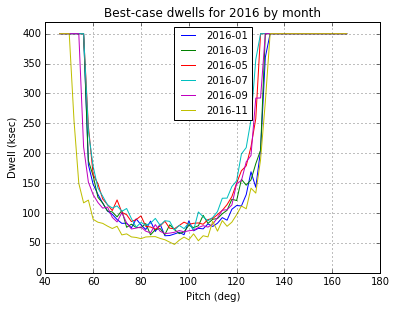

In [2]:
"""Plot best-case constraints for 2014 in 2-month intervals"""
import matplotlib.pyplot as plt

import pyger
% matplotlib inline

# Set up the font sizes and initialize figure
plt.rc("axes", labelsize=10, titlesize=12)
plt.rc("legend", fontsize=10)
plt.figure(1, figsize=(6,4.5))
plt.clf()

max_dwell_ksec = 400.

# Step through 2014 in 2-month intervals
for month in range(0, 12, 2):
    start = '2016-%02d-01T00:00:00' % (month+1)
    print '*** Calculating constraints for %s ***' % start
    constraints = pyger.calc_constraints(start=start,
                     n_sim=1000,
                     dt=1000.,
                     max_aacccdpt=-12.5,
                     max_tcylaft6=999.0,
                     max_1pdeaat=999.0,
                     max_1dpamzt=999.0,
                     max_pftank2t=999.0,
                     n_ccd=4,
                     sim_file='sim_inputs.pkl',
                     max_dwell_ksec=max_dwell_ksec,
                     min_pitch=45,
                     max_pitch=169,
                     bin_pitch=2,
                     constraint_models=('aca',))
    
    dwell1_stats = constraints['all'].dwell1_stats
    plt.plot(dwell1_stats['pitch'], dwell1_stats['dur90'] / 1000, label=start[:7])

    
# Finish making the plot with labels and then save to a file
plt.title('Best-case dwells for 2016 by month')
plt.legend(loc='upper center')
plt.xlabel('Pitch (deg)')
plt.ylabel('Dwell (ksec)')
plt.grid()
plt.ylim(0, max_dwell_ksec * 1.05)
plt.savefig('dwells_2016_month.png')

The output of the `pyger.calc_constraints` function needs a little explanation. As can be seen from the script this function returns a single value which is a Python dict containing a key/value pair for each of the constraint models. In this case only the `aca` model is shown, with the data under `all` originally intended to include the global dwell limitations considering all models included in the simulation run. Although the effect of multiple constraint models can be incorporated, and was once often the case, due to the time it takes to run the miriad of permutations relevant for each model, along with the complexity of the interactions between models, it is suggested that data from individual models be run separately.

In [3]:
constraints

{'aca': <pyger.pyger.ConstraintAca at 0x121856450>,
 'all': <pyger.base.ConstraintModel at 0x1244ae650>}

A ConstraintModel object has a number of attributes that can be discovered with the `dir` built in python function.

In [4]:
dir(constraints['aca'])

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calc_model',
 '_get_init_comps',
 '_get_model_temps',
 '_get_states1',
 '_set_init_comps',
 'calc_dwell1_T0s',
 'calc_dwell1_stats',
 'calc_dwells1',
 'calc_dwells2',
 'dwell1_stats',
 'dwells1',
 'find_limit_crossings',
 'find_long_hot_pitch_dwells',
 'limits',
 'max_dwell_ksec',
 'model_spec',
 'msids',
 'n_sim',
 'name',
 'sim_inputs',
 'start',
 'state_cols',
 'times']

The most important are:

 - dwells1: dwell pitch, duration, and constraint name for each simulated dwell

 - dwell1_stats: binned statistics for the dwells

These are both NumPy record arrays (i.e. a table). The available columns for each indivdual model are:

In [5]:
print constraints['aca'].dwells1.dtype.names

('pitch', 'T0s', 'times', 'Ts', 'constraint_name', 'duration')


In [6]:
print constraints['aca'].dwell1_stats.dtype.names

('pitch_bin0', 'pitch_bin1', 'pitch', 'dur50', 'dur90')


The available columns in `constraints['all'].dwells1` do not include the `T0s`, `times` and `Ts` columns since these latter columns contain data specific to each simulation and are not relevant to the composite maximum dwell time.

In [7]:
print constraints['aca'].dwells1.dtype.names

('pitch', 'T0s', 'times', 'Ts', 'constraint_name', 'duration')


The columns are accessed as follows, for example:

    dwells1 = constraints['all'].dwells1
    plt.plot(dwells1['pitch'], dwells1['duration'], '.')

The code used by the pyger module to make a standard plot is illustrative of useful techniques for scripting and plotting. This function will be used below to generate a composite plot of hot dwell capability using a new set of limits. Note the filtering by constraint name:

In [32]:
def plot_dwells1(constraint, plot_title=None, plot_file=None, figure=1):
    """Make a simple plot of the dwells and dwell statistics for the constraint.

    :param constraint: ConstraintModel object (e.g. constraints['all'])
    :param plot_title: plot title
    :param plot_file: output file for plot
    :param figure: matplotlib figure ID (default=1)
    """
    plt.rc("axes", labelsize=10, titlesize=12)
    plt.rc("xtick", labelsize=10)
    plt.rc("ytick", labelsize=10)
    plt.rc("font", size=10)

    dwells1 = constraint.dwells1
    dwell1_stats = constraint.dwell1_stats
    plt.figure(figure, figsize=(6,4))
    plt.clf()
    ok = dwells1['constraint_name'] == 'aacccdpt'
    plt.plot(dwells1['pitch'][ok], dwells1['duration'][ok] / 1000., '.',
             markersize=3, label='aca', mec='c')
    plt.plot(dwell1_stats['pitch'], dwell1_stats['dur50'] / 1000., '-r')
    plt.plot(dwell1_stats['pitch'], dwell1_stats['dur90'] / 1000., '-m')
    plt.grid()
    plt.title(plot_title or '')
    plt.xlabel('Pitch (deg)')
    plt.ylabel('Dwell (ksec)')
    plt.ylim(constraint.max_dwell_ksec * -0.05, constraint.max_dwell_ksec * 1.05)
    plt.subplots_adjust(bottom=0.12)
    if plot_file:
        logger.info('Writing constraint plot file {0}'.format(plot_file))
        plt.savefig(plot_file)

Recalculate the constraints object and store it in the object named `hot_constraints`.

In [20]:
models = ('aca',)

hot_constraints = pyger.calc_constraints(start='2016:001',
                                                   n_sim=1000,
                                                   dt=1000.,
                                                   max_aacccdpt=-12.5,
                                                   n_ccd=5,
                                                   sim_file='sim_inputs.pkl',
                                                   max_dwell_ksec=400.,
                                                   min_pitch=45,
                                                   max_pitch=169,
                                                   bin_pitch=2,
                                                   constraint_models=models)

ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells


Now plot the composite of all constraints using the built in `plot_dwells1` function. This plot shows the Monte-Carlo sampling of different starting conditions at each pitch. The different dot colors represent the limiting constraint. The lower red line shows the median allowed dwell time within each 2 degree pitch bin. The upper magenta line shows the 90% value in each bin and represents a reasonable "best case" at that pitch.

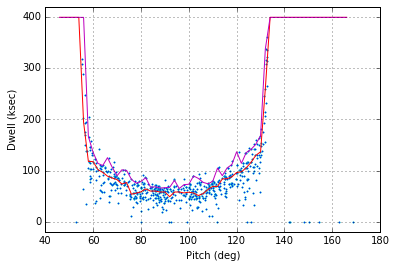

In [33]:
plot_dwells1(hot_constraints['aca'])

### Cooldown Dwell Simulations

As hot dwell capability in all pitch regions becomes more constrained, we need to start considering the required cooling time to adequately balance hot and cool time for all relevant constraints.

Cooldown time is calculated on an individual constraint basis, so only one MSID of interest should be used for each set of hot and cool dwell simulations when cooldown time needs to be calculated. Mixing multiple MSIDs/constraints in this context will result in unintuitive and/or unusable results.

Since we need to start with a clean set of hot dwell simulations that contain only one limiting constraint, first create the `hot_constraints` object using the same syntax used above. We'll focus on AACCCDPT only for this example by setting the limits for all other constraints well beyond an observable value, 999.0 should be more than adequate. When focusing only on one constraint, one should also limit the models run to the model used to calculate the constraint of interest using the `constraint_models` keyword as shown below.

Since generating Pyger data can be time consuming and should be pre-calculated in batch jobs, a method for saving both the heatup and cooldown data has been included. This tutorial will show how to save this data. If a large survey of dwell capability is being generated, such as for the development of an LTS, it is recommended that the user generate individual MSID data for all msids, dates, and limits separately. This data can then be read in and combined according to the users' needs.

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from Chandra.Time import DateTime

import pyger

hot_constraints = pyger.calc_constraints(start='2016:001',
                     n_sim=1000,
                     dt=1000.,
                     max_tcylaft6=999.0,
                     max_1pdeaat=999.0,
                     max_1dpamzt=999.0,
                     max_pftank2t=999.0,
                     max_aacccdpt=-12.5,
                     n_ccd=4,
                     sim_file='sim_inputs.pkl',
                     max_dwell_ksec=400.,
                     min_pitch=45,
                     max_pitch=169,
                     bin_pitch=2,
                     constraint_models=('aca',))

ACA: calculating start temps for 300 dwells
ACA: simulating 1000 dwells


The `save_pyger_pickle` method saves all pickleable attributes of the constraints object.

In [35]:
pyger.save_pyger_pickle(hot_constraints, 'demo_dwell1.pkl')

Since we only included one model in the `constraints_models` keyword, only the `minus_yz` data is returned. The data stored by the `all` key will only include the impacts of limiting TCYLAFT6.

In [36]:
hot_constraints

{'aca': <pyger.pyger.ConstraintAca at 0x12743ebd0>,
 'all': <pyger.base.ConstraintModel at 0x122f77cd0>}

Below is a plot of max hot dwell duration using the built in plotting routine discussed and shown above.

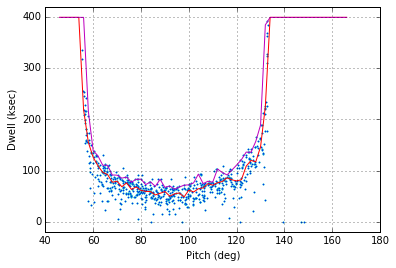

In [37]:
plot_dwells1(hot_constraints['aca'])

Generating the cooldown data is accomplished similarly to how the heatup data is generated. Note that three objects are returned and each of these objects are Numpy arrays, not `ConstraintModel` class types. 

 - `cool_constraints` contains all of the relevant data from the cooldown simulations. 

 - `coolstats` includes relevant cooldown dwell statistical data.

 - `hotstats` includes the relevant hot dwell durations for comparison to the cooldown data.

Although the hot dwell data is used to generate the starting conditions for the cooldown simulations, the maximum hot dwell durations initially calculated from these data are not directly relevant to the cooldown simulations. The original maximum hot durations are general statistical values (90th percentile line for example) for all pitch regions and do not include the actual ending conditions necessary to serve as initial conditions for the cooldown simulations. This will be discussed and illustrated in detail below.

First lets dissect each of the keywords used by the `pyger.calc_constraints2` function before running it.

- `start='2016:001'`: This is the date for which the cooldown time is calculated and will usually match the start time used for the cooresponding hot dwell calculations. It is conceivable that one would want to adjust this date to account for the time used during the hot dwell calculations, however the difference in seasonal impacts between the start and end of the hot dwell should be negligible for dwell durations that the xija models are calibrated for.

- `n_ccd=None`: If this is set to `None`, pyger uses the number of ACIS CCDs specified during the hot dwell simulations, if relevant to the model.

- `max_dwell_ksec=600`: This is the length of time in kiloseconds each cooldown simulation is run. Since it often takes longer to cool down a constraint compared to the time to reach the temperature limit, this keyword should be set to a time in kiloseconds much longer than the time used for the hot dwell; 600 kiloseconds is often adequate for the cooldown simulations.

- `pitch_num=50`: This is the number of pitch values simulated in the 'not hot' regions for each hot dwell simulation. This results in a total of NxM cooldown simulations where N is the number of hot simulations and M is the number specified in `pitch_num`.

- `pitch_range=None`: This is the range of pitch values within which to simulate cooldown dwells. When this keyword is set to `None`, Pyger uses all pitch values previously used in the hot dwell simulations which did not reach the specified temperature limit. If this keyword is set to a two element tuple or list of pitch values, then Pyger selects a uniform distribution of pitch values within the specified values. This is useful in cases where the model configuration changes between the hot and cool dwell simulations, particularly if the heatup dwell uses 6 ACIS CCDs and the cooldown dwell uses 4 ACIS CCDs, or visa versa.

- `hot_dwell_temp_ratio=1.0`: This keyword governs the starting conditions used for each cooldown simulation. This ratio specifies the temperature ratio between the HOT dwell starting temperature (when cooler) and the HOT dwell ending temperature (at the temperature limit). A ratio of 1.0, as in this case, specifies that the model temperatures at the hot dwell ending temperature (for the MSID/constraint of interest) should be used for the initial conditions for the cooldown simulation. A ratio of 0.8 specifies that the starting conditions for the cooldown simulation should be taken when the MSID of interest reached a delta temperature ratio of 0.8 between the starting and ending HOT dwell simulation. This can be useful if the user is interested in how the heatup and cooldown times compare when operating away from the temperature limit. Note that the `hot_dwell_temp_ratio` should not be less than `1.0 - T_cool_ratio`.

- `T_cool_ratio=0.9`: This keyword governs when a cooldown simulation reaches the 'cooled' state. This ratio is also relative to the temperatures spanned during the hot dwell simulation. A ratio of 0.9 means that the MSID, or constraint, of interest has cooled when the temperature reaches 90% of the {\Delta}T between the temperature limit and the original starting temperature in the hot dwell simulation. It is recommended that a value of 1.0 not be used since Pyger will then only show which pitch regions cool to the very lowest temperatures and will show some cooling regions as neutral. The goal of these cooldown simulations is to show which regions cool in general; the regions that provide the most/fastest cooling will invariably show shorter cooling times regardless of what `T_cool_ratio` is used. 

- `constraint_models`=('aca',): This is currently input as a tuple and should include only the model of interest. Note that the comma after the first entry within the parentheses is necessary, otherwise Python will not interpret this as an iterable object.

- `msids=('aacccdpt',)`: This specifies the MSID, or constraint, of interest. As with the `constraint_models`, this should be a one element tuple.

It is understood that the use of tuples for the last two keywords adds unnecessary complexity; this construct will likely be simplified in the future.

NOTE: There is a bug in how the `hot_temp_dwell_ratio` is used for values less than 1.0, for now only use ratios of 1.0.

Next, take a look at the output of this function.

In [38]:
cool_constraints, coolstats, hotstats = pyger.calc_constraints2(
                                                    hot_constraints,
                                                    start='2016:001',
                                                    n_ccd=None,
                                                    max_dwell_ksec=600.,
                                                    pitch_num=50,
                                                    pitch_range=None,
                                                    hot_dwell_temp_ratio=1.0,
                                                    T_cool_ratio=0.9,
                                                    constraint_models=('aca',),
                                                    msids=('aacccdpt',))

aacccdpt - ACA: simulating 50 cooldown dwells for each of the 122 hot dwells
Using a hot dwell temperature ratio of 1.0 to determine cooldown dwellstarting conditions
ACA: simulating cooldown dwells for hot dwell 1 of 122
ACA: simulating cooldown dwells for hot dwell 2 of 122
ACA: simulating cooldown dwells for hot dwell 3 of 122
ACA: simulating cooldown dwells for hot dwell 4 of 122
ACA: simulating cooldown dwells for hot dwell 5 of 122
ACA: simulating cooldown dwells for hot dwell 6 of 122
ACA: simulating cooldown dwells for hot dwell 7 of 122
ACA: simulating cooldown dwells for hot dwell 8 of 122
ACA: simulating cooldown dwells for hot dwell 9 of 122
ACA: simulating cooldown dwells for hot dwell 10 of 122
ACA: simulating cooldown dwells for hot dwell 11 of 122
ACA: simulating cooldown dwells for hot dwell 12 of 122
ACA: simulating cooldown dwells for hot dwell 13 of 122
ACA: simulating cooldown dwells for hot dwell 14 of 122
ACA: simulating cooldown dwells for hot dwell 15 of 122
AC

The output echos some of the relevant input information, and shows the progress as each hot dwell is used to seed a set of cooldown simulations. Although, due to the random nature of how the hot dwells are selected, the actual number hot hot dwells used will change with each run, this example should find roughly a hundred or so hot dwells to use.

Next you will see that the first output, assigned to `cool_constraints` is actually a one element list. This is also an example of unnecessary complexity that will be removed in the future. For now, we'll just assign the sole element to the same variable name. In fact, each of the outputs are single element lists so the single element will be assigned the variable name of its parent.

In [39]:
cool_constraints.keys()

['aacccdpt']

In [40]:
cool_constraints = cool_constraints['aacccdpt']
coolstats = coolstats['aacccdpt']
hotstats = hotstats['aacccdpt']

Save these arrays to a pickle file directly using the pickle module

In [41]:
import pickle
saved_data = {'msid':'aacccdpt',
              'cool_constraints':cool_constraints,
              'hotstats':hotstats,
              'coolstats':coolstats}
pickle.dump(saved_data, open('demo_dwell2.pkl', 'w'), protocol=2)

Next lets review the columns/fields available in the `cool_constraints` array. Each row corresponds to one hot dwell used to seed a set of cooldown simulations. The columns are the names shown below and correspond to the data stored in each element. Since there are many cooldown simulations run for each hot simulation, some of these individual elements will contain arrays.

- `dwell1_ind`: This is the index into the original `dwells1` array in the hot dwells constriaints object used as the seed for this set of cooldown dwells.

- `dwell1_pitch`: This is the original pitch used during the hot dwell.

- `msid`: This is the MSID, or constraint, of interest.

- `dwell1_duration_delta`: This is the duration during the HOT dwell that is equivalent to the time between the 'cooldown' temperature (as governed by the `T_cool_ratio`) and the starting conditions for each the cooldown simulations. This returns a single value for each row.

- `dwell1_duration`: This returns the full duration, from the initial temperature to the limit, for the original hot dwell. This returns a single value for each row.

- `T_dwell1_0`: This contains the starting conditions for the initial hot dwell simulation. This returns a list of values, where each element corresponds to the initial temperature for each node in the model.

- `T_dwell2_0`: This contains the starting conditions for the cooldown dwell simulation. This returns a list of values, where each element corresponds ot hte initial temperature for each node in the model.

- `dwell2_pitch_set`: This is the set of 'not hot' pitch values used for each of the cooldown simulations.

- `dwell2_times`: This is the set of cooldown durations, where each duration represents the time it took to go from the cooldown starting conditions to the 'cooled' temperature (governed by the `T_cool_ratio`). This returns a list of times, with a length equal to the number of cooldown simulations run. Also each of these times corresponds, in order, to the list of pitch values in `dwell2_pitch_set`. Not all cooldown simulations will reach a 'cooled' state. Simulations in neutral pitch regions will finish the simulation when the maximum dwell time length `max_dwell_ksec` has been reached.

- `dwell2_cool_temp`: This is the 'cooled' temperature that each of the cooldown simulations need to reach in order to be considered cooled. 

These fields/columns are shown below.

In [42]:
cool_constraints.dtype.names

('dwell1_ind',
 'dwell1_pitch',
 'msid',
 'dwell1_duration_delta',
 'dwell1_duration',
 'T_dwell1_0',
 'T_dwell2_0',
 'dwell2_pitch_set',
 'dwell2_times',
 'dwell2_cool_temp',
 'dwell1_start',
 'dwell2_start')

Now lets look at the `coolstats` array. This array is similar to `hot_constraints['minus_yz'].dwell1_stats` in that it includes statistical data that is useful for plotting. The `perc10`, `perc50`, `perc90` fields contain the 10th, 50th, and 90th percentile values for the cooldown times for each pitch. The cooldown time denoted by the `perc10` column represents the time it will take the constraint to reach the cooled state 10% of the time; this could be considered an exceedingly optimistic (short) cooldown time. The `perc90` column denotes the time that it will take the constraint to reach the cooled state 90% of the time; this would be considered the conservative (longer) cooldown time.

In cases where factors other than attitude also impact temperature, there may be a very large variation in cooldown time. In some of these cases the 90th percentile cooldown time may reach the maximum dwell time for the set of cooldown simulations, while the 10th percentile time will be substantially lower. This is a real and expected behavior that stems from the impacts of other nodes and power states (such as from the number of ACIS CCDs used). In the case of models impacted by ACIS CCDs, remember that if the MSID/constraint needs to be cooled following a hot observation, the subsequent observation will use a reduced number of CCDs, or an HRC observation will be scheduled.

In [43]:
coolstats.dtype.names

('pitch', 'perc10', 'perc50', 'perc90')

The `hotstats` array contains relevant statistical information regarding the hot dwells used to seed each set of cooldown dwells. The `dwell1_duration` column contains the duration for each hot dwell. The `dwell1_duration_delta` contains the fraction of heatup time relevant to the cooldown dwell times. The data in these two columns will be explained in further detail below.

There is a very important difference between this information and the data present in `hot_constraints['minus_yz'].dwell1_stats`. The `dwell1_stats` array contains generalized statistical data and does not contain data specific to each heatup dwell. This specific information is necessary to set up the startup conditions for each set of cooldown simulations. The `hotstats` array contains dwell duration data for each individual hot dwell simulation picked to seed each set of cooldown simulations, in the `pitch` and `dwell1_duration` columns. The `dwell1_duration_delta` column requires more explanation on how the set of hot dwells are selected to seed each set of cooldown simulations.

Both the `coolstats` and `hotstats` arrays were originally generated to make plotting relevant data simpler, compared to navigating the primary dataset `cool_constraints`. I am rethinking this strategy and may eventually combine all three outputs of `pyger.calc_constraints2`.

Much of the code used for the following discussion will go beyond what is needed for normal analyses.

In [44]:
hotstats.dtype.names

('pitch', 'dwell1_duration', 'dwell1_duration_delta')

Before explaining what `dwell1_duration_delta` represents lets look at how the cooldown dwell data is calculated. First we should look at all the heatup dwells included in the original `hot_constraints['aca'].dwells1` datastructure. This contains the results of each node in the `aca` model for each hot dwell simulation, regardless of whether or not the temperature reached the specified limit(s). The plot below shows the temperature for `aacccdpt` for each simulation.

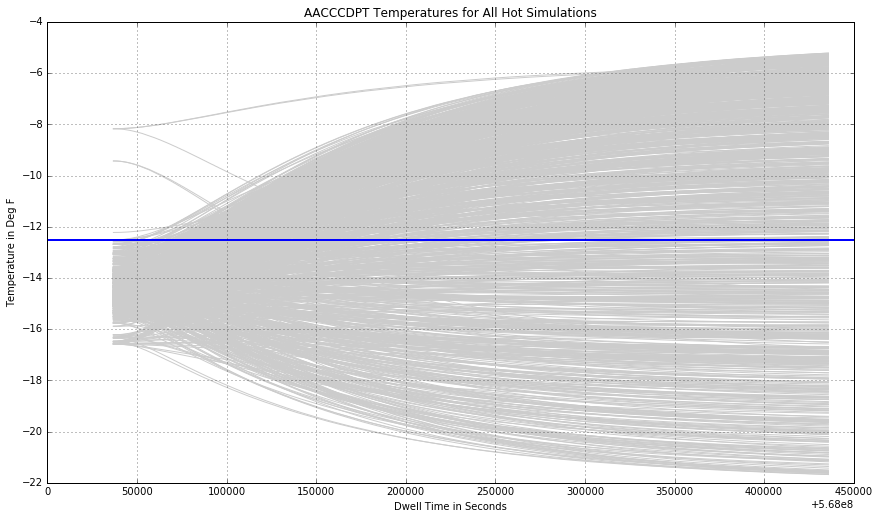

In [46]:
# Create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot each hot dwell simulation
for d in hot_constraints['aca'].dwells1:
    aca_times = d.times
    aca_temps_deg_F = d.Ts[0]
    ax.plot(aca_times, aca_temps_deg_F, color=[0.8,0.8,0.8])
    
# Format the plot
ax.grid()
ax.plot(ax.get_xlim(), [-12.5, -12.5], 'b', linewidth=2)
ax.set_title('AACCCDPT Temperatures for All Hot Simulations')
ax.set_ylabel('Temperature in Deg F')
ax.set_xlabel('Dwell Time in Seconds')

We are not interested in simulating the cooldown time from dwells that don't reach the specified limit, so the dwells that do not reach the limit are filtered out as shown below. 

611 dwells used out of 1000 initial simulations.


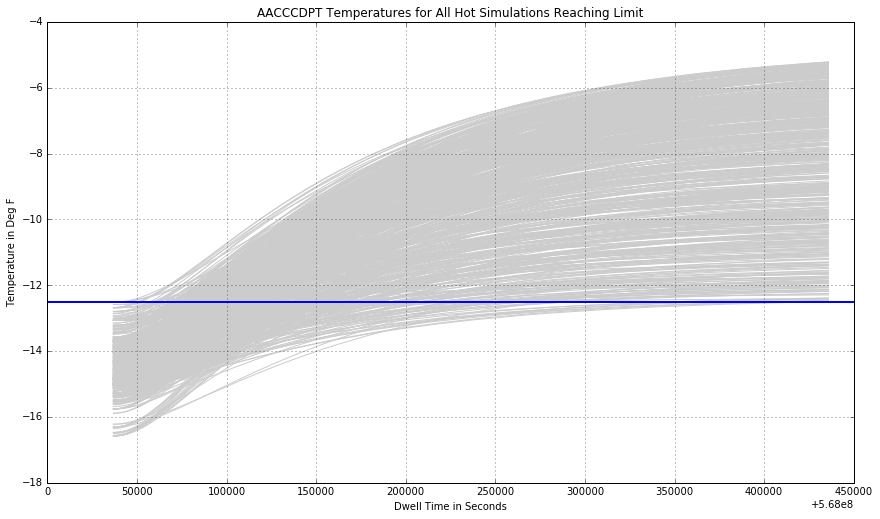

In [53]:
# Create figure.
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot each hot dwell simulation if the max hot dwell duration is less than 90% of 
# the max dwell time.
# Filter out all dwell durations that show zero time.
for d in hot_constraints['aca'].dwells1:
    aca_times = d.times
    aca_temps_deg_F = d.Ts[0]
    dwell_duration = d.duration
    max_dwell_sec = hot_constraints['aca'].max_dwell_ksec * 1000
    if (dwell_duration < max_dwell_sec) & (dwell_duration > 0.0):
        ax.plot(aca_times, aca_temps_deg_F, color=[0.8,0.8,0.8])


num_reach_limit = np.sum((hot_constraints['aca'].dwells1.duration < max_dwell_sec) & 
                         (hot_constraints['aca'].dwells1.duration > 0.0))
print('{} dwells used out of {} initial simulations.'.format(num_reach_limit, len(hot_constraints['aca'].dwells1)))
        
# Format the plot.
ax.grid()
ax.plot(ax.get_xlim(), [-12.5, -12.5], 'b', linewidth=2)
ax.set_title('AACCCDPT Temperatures for All Hot Simulations Reaching Limit')
ax.set_ylabel('Temperature in Deg F')
ax.set_xlabel('Dwell Time in Seconds')

Since we want each cooldown dwell to be paired with a best effort hot dwell, so that maximum likely cooldown time is comparable to maximum likely heatup time, the hot dwell simulations that reach the specified limit with the lowest starting temperatures are used. Specifically, of the dwells that reach the specified limit, those with starting temperatures at or under the 20th percentile are selected to seed the cooldown dwells.

611 dwells used out of 1000 initial simulations.
122 dwells used to define "best effort, lowest starting temperature" cases.


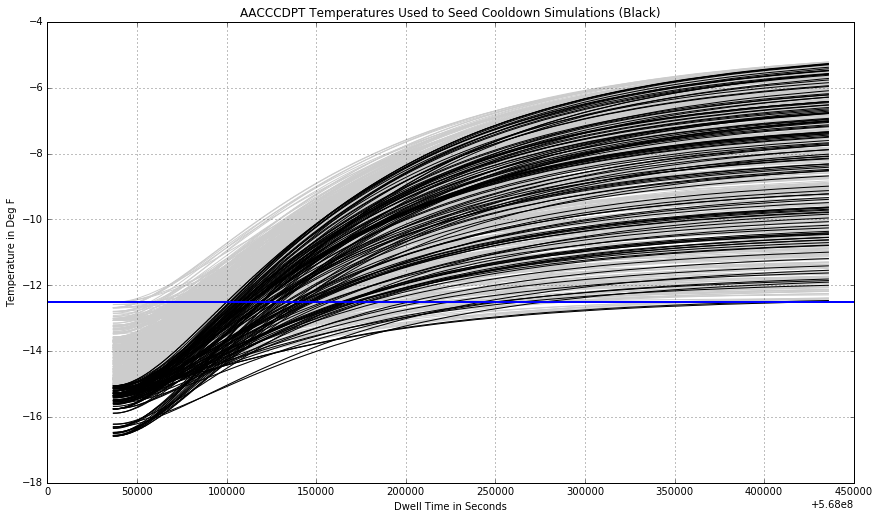

In [60]:
def find_lowest_starting_temp_indices(hot_constraints, model, msid, perc=0.2):
    """ Determine indices into dwells1 for hot dwells with lowest starting temps.

    :param hot_constraints: Output from pyger.calc_constraints() (hot dwells)
    :param model: Model of interest
    :param msid: MSID of interest
    :param perc: Bottom ratio of starting temperatures
    """
    
    msid_ind = hot_constraints[model].msids.index(msid)
    good_sim = hot_constraints[model].dwells1['duration'] > 0
    hot_pitch_ind_all = np.flatnonzero(
                            (hot_constraints[model].dwells1['constraint_name']
                             != 'none') & good_sim)
    start_temps = hot_constraints[model].dwells1['T0s'][hot_pitch_ind_all]
    start_temps_transpose = start_temps.transpose()
    sort_ind = start_temps_transpose[msid_ind].argsort() 
    ind = range(int(len(start_temps_transpose[0]) * perc))
    lowest_temps_ind = sort_ind[ind]
    
    return hot_pitch_ind_all[lowest_temps_ind]

# Call function to find indices of hot dwells of interest.
msid = 'aacccdpt'
model = 'aca'
hot_pitch_ind = find_lowest_starting_temp_indices(hot_constraints, model, 
                                                  msid, perc=0.2)

# Create figure.
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot each hot dwell simulation
# Filter out all dwell durations that show zero time.
for d in hot_constraints['aca'].dwells1:
    aca_times = d.times
    aca_temps_deg_F = d.Ts[0]
    dwell_duration = d.duration
    max_dwell_sec = hot_constraints['aca'].max_dwell_ksec * 1000 
    if (dwell_duration < max_dwell_sec) & (dwell_duration > 0.0):
        ax.plot(aca_times, aca_temps_deg_F, color=[0.8,0.8,0.8])

num_reach_limit = np.sum((hot_constraints['aca'].dwells1.duration < max_dwell_sec) & 
                         (hot_constraints['aca'].dwells1.duration > 0.0))
str1 = '{} dwells used out of {} initial simulations.\n'.format(
        num_reach_limit, len(hot_constraints['aca'].dwells1))
str2 = '{} dwells used to define "best effort, lowest starting temperature" cases.'.format(len(hot_pitch_ind))
print('{}{}'.format(str1, str2))



# Plot hot dwells of interest in black.
for d in hot_constraints['aca'].dwells1[hot_pitch_ind]:
    aca_times = d.times
    aca_temps_deg_F = d.Ts[0] 
    ax.plot(aca_times, aca_temps_deg_F, color=[0,0,0]) 

# Format plot.
ax.grid()
ax.plot(ax.get_xlim(), [-12.5, -12.5], 'b', linewidth=2)
ax.set_title('AACCCDPT Temperatures Used to Seed Cooldown Simulations (Black)')
ax.set_ylabel('Temperature in Deg F')
ax.set_xlabel('Dwell Time in Seconds')

Next look at an example heatup/hot dwell and a subsequent cooldown dwell. You'll see that in this case the cooldown dwell does not reach the starting temperature observed at the begining of the heatup dwell. There are some cases where the heatup dwell starting temperature can easily be achieved, but this will not always be the case.

First find a good example cooldown dwell to use for this discussion

In [73]:
cool_pitch_vals = cool_constraints.dwell2_pitch_set[0][:]
inds = np.arange(len(cool_pitch_vals))[(cool_pitch_vals > 145 & 
                                        (cool_pitch_vals < 150))]

The progression of temperatures during each cooldown dwell is not saved, so to plot these tempemperatures, they need to be recalculated. This is not normally something you would need to do, however it is useful for this discussion.The following code recalculates these temperatures. Also note that the process to find an ideal dwell case to illustrate how temperatures will not always cool back down the original heatup dwell starting temperature can be a bit iterative. 

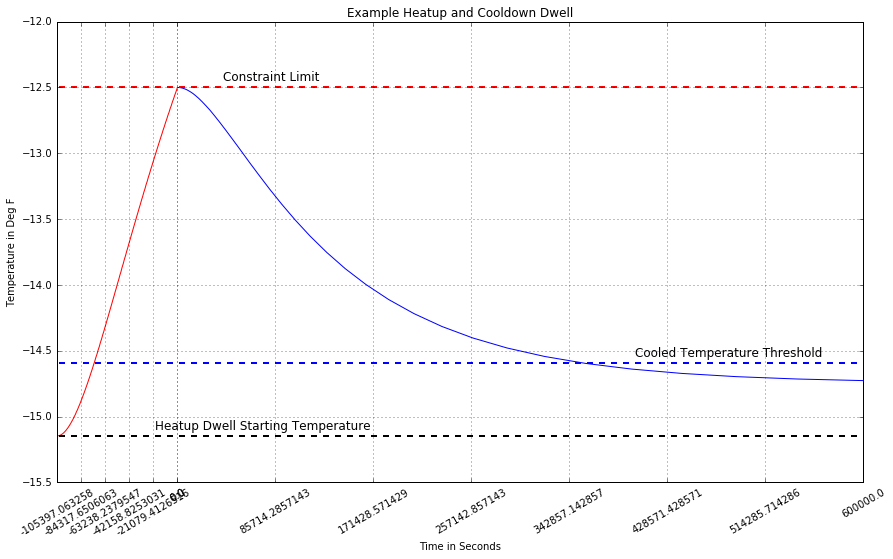

In [92]:
example_ind = inds[15]

# Time values for the cooldown dwell (uses initial hot dwell time so date is approx. 
# correct)
start = hot_constraints['aca'].start
max_dwell_ksec = 600 # value used for pyger.constraints2() input
stop = DateTime(start.secs + max_dwell_ksec * 1000)
norm_profile = np.linspace(0, 1, 100)**10 # nonlinear time resolution
times = start.secs + norm_profile * (stop.secs - start.secs)
cool_times = times - times[0] # relative times useful for plotting

# Obtain the temperature at which temperatures in the cooldown dwell are considered
# 'cooled'
T_cooled = cool_constraints.dwell2_cool_temp[example_ind] 

# Obtain one of the target pitch values in the set of cooldown dwells
cool_pitch = cool_constraints.dwell2_pitch_set[0][example_ind]

# Re-use the original _get_states1 function to assemble states to calculate the 
# cooldown temperatures
states2 = hot_constraints['aca']._get_states1(start, stop, cool_pitch)

# Obtain the initial model temperatures for the example cooldown dwell
T_dwell2_0 = cool_constraints.T_dwell2_0[example_ind]

# Re-calculate the temperatures during the cooldown dwell example
Ts_cool = hot_constraints['aca']._calc_model(states2, times, [T_dwell2_0,])

# Save information for the example hot seed dwell
hot_ind = cool_constraints.dwell1_ind[example_ind]

# Obtain temperatures during hot seed dwell
hot_temps = hot_constraints['aca'].dwells1[hot_ind].Ts[0]

# Find indexes in hot_temps where temperatures are <= limit
ind_under_limit = hot_temps <= -12.5

# Add limit temperature to hot_temps to make plot flow better
hot_temps = list(hot_temps[ind_under_limit])
hot_temps.append(-12.5)
hot_temps = np.array(hot_temps)

# Add duration to match temp. limit added above
duration = hot_constraints['aca'].dwells1[hot_ind].duration
hot_times = hot_constraints['aca'].dwells1[hot_ind].times - hot_constraints['aca'].dwells1[hot_ind].times[0]
hot_times = list(hot_times[ind_under_limit])
hot_times.append(duration)

# Make hot_times start negative and move towards zero for plotting purposes
hot_times = np.array(hot_times) - hot_times[-1]

# Define x tick mark locations
xtick = np.concatenate((np.linspace(hot_times[0], hot_times[-1], 6), 
                        np.linspace(cool_times[0], cool_times[-1], 8)), axis=0)

# Define figure and plot relevant information
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.plot(cool_times, Ts_cool[0])
ax.plot(hot_times, hot_temps,'r')
ax.plot(ax.get_xlim(), [-12.5, -12.5], 'r--', linewidth=2)
ax.plot(ax.get_xlim(), [T_cooled, T_cooled], 'b--', linewidth=2)
ax.plot(ax.get_xlim(), [hot_temps[0], hot_temps[0]], 'k--', linewidth=2)

ax.set_xticks(xtick)
ax.set_xlim((xtick[0], xtick[-1]))
ax.set_xticklabels(xtick, rotation=30)
ax.grid()

ax.text(40000, -12.5+.05, 'Constraint Limit', fontsize=12)
ax.text(400000, T_cooled+0.05, 'Cooled Temperature Threshold', fontsize=12)
ax.text(-20000, hot_temps[0]+0.05, 'Heatup Dwell Starting Temperature', fontsize=12)

ax.set_title('Example Heatup and Cooldown Dwell')
ax.set_ylabel('Temperature in Deg F')
ax.set_xlabel('Time in Seconds')

If you are running this notebook independantly you will have a different random set of hot dwells and you may notice that the final temperature is above the 'Cooled Temperature Threshold' or below the 'Heatup Dwell Starting Temperature', however it is important to note that the latter case will not always be common. For some constraints, the minimum temperature will only be achievable at a cool attitude within a narrow pitch range, or in the case of the ACIS related constraints, the starting hot dwell starting temperatures as chosen above may not be achievable. This latter case is possible when the hot dwell started following an HRC observation, then 5 or 6 chips are used for both the heatup and cooldown dwell. 

Adding a pad in the form of the 'Cooled Temperature Threshold' shown above expands the range that will reveal pitch ranges that will cool the constraint. The downside of using such a pad is that it changes the temperature range the reported cooldown time is relative to, so the cooldown time is relative to a different temperature change compared to the heatup dwell. Since we want the heatup time and the cooldown time to be relative to the same change in temperature, the time between the start of the heatup dwell and the point where the heatup dwell heats up to the 'Cooled Temperature Threshold' is removed from the heatup dwell time and saved as the `dwell1_duration_delta` column in both the `hotstats` and `cool_constraints` arrays. The ratio of heatup time and cooldown time between the values reported by `dwell1_duration_delta` and the statistical values reported in the `coolstats` arrays are the values that should be used to determine the ratio of required heating to cooling time when assembling the LTS.

Next a standard cooldown plot is generated. 

- The black line represents the traditional best-case pyger maximum dwell capabiltiy in two degree pitch bins. Specifically this is the mean line through the hot dwell cases with "best effort" cool starting tempreatures. In the case of this example, it is the mean through the allowed dwell time values for heatup dwells with the 20% lowest starting temperatures.
- The orange datapoints represent the heatup time from the `T_cooled` threshold to the limit (not from the starting temperature to the limit) for each hot dwell used to seed a set of cooldown simulations. 
- The orange line is the mean through these data.
- The blue datapoints represent the amount of time required to reach the `T_cooled` threshold for each cooldown simulation. 
- The blue lines represent the `perc10`, `perc50`, and `perc90` cooldown times that are comparable to the hot dwell data depicted in orange. The `perc10` line shows the amount of time required to cool this constraint 10% of the time (reports lowest time) where the `perc90' shows the amount of time required to cool this constraint 90% of the time (reports greatest time values)

Finally, to provide an example of how this plot should be used, consider a hot dwell at a pitch of 70 degrees and a cool dwell at a pitch of 150 degrees. To understand the ratio of required heating to cooling time, use the maximum dwell time at 70 degrees pitch as denoted by the orange line and compare it to the cooling time at a pitch of 150 degrees using the 90th percentile blue line (top line). Using the data available at the time this example was generated, the max hot time of approximately 75 Ks would require a cooling time of no more than 160 Ks to reach the original hot dwell starting temperature (or lower) 90% of the time.

In [103]:
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
lightfont = mpl.font_manager.FontProperties(weight='light')
minorLocator   = AutoMinorLocator(2)

def plot_cooldown(constraints2, coolstats, hotstats, model, msid, limit, filename=None, 
                  save_to_file=False, additional_title_text=None):
    
    colorpalate = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    lightblue = "#81CCf4"

    if additional_title_text is None:
        additional_title_text = ''

    # Create plot framework
    fig = plt.figure(figsize=[14,8], facecolor='w')
    rect = [0.1, 0.1, 0.88, 0.8]
    ax = fig.add_axes(rect)


    if len(np.array(hotstats).flatten()) > 0:

        # fill in NaNs in cool stats for hot regions, sort by pitch
        nans = np.array([np.nan] * len(hotstats.pitch))
        coolpitch = np.concatenate((coolstats.pitch, hotstats.pitch), axis=0)
        coolperc10 = np.concatenate((coolstats.perc10, nans), axis=0)
        coolperc50 = np.concatenate((coolstats.perc50, nans), axis=0)
        coolperc90 = np.concatenate((coolstats.perc90, nans), axis=0)
        ind = coolpitch.argsort()
        coolpitch = coolpitch[ind]
        coolperc10 = coolperc10[ind]
        coolperc50 = coolperc50[ind]
        coolperc90 = coolperc90[ind]

        # Plot data
        ax.plot(constraints2.dwell2_pitch_set, constraints2.dwell2_times, '.', 
                color=lightblue, alpha=0.1)
        ax.fill_between(coolpitch, coolperc10, coolperc90, facecolor=colorpalate[1], alpha=0.5)
        ax.plot(coolpitch, coolperc50, label='50 Perc Cooldown Time', linewidth=3, color=colorpalate[1])
        ax.plot(coolpitch, coolperc10, label='10 Perc Cooldown Time', linewidth=2, color=colorpalate[1])
        ax.plot(coolpitch, coolperc90, label='90 Perc Cooldown Time', linewidth=2, color=colorpalate[1])

        ax.plot(hotstats.pitch, hotstats.dwell1_duration,
                linewidth=4, color=[0.4, 0.4, 0.4], label='Max Dwell Time')

        dwell1pitch = constraints2.dwell1_pitch
        #duration = constraints2.dwell1_duration
        duration_delta = constraints2.dwell1_duration_delta

        ax.plot(dwell1pitch, duration_delta, '.', color=colorpalate[0], alpha=0.4)
        ax.plot(hotstats.pitch, hotstats.dwell1_duration_delta, color=colorpalate[0], 
                label='Heatup Time From Tcooled to Limit', linewidth=3)
        ax.fill_between(hotstats.pitch, 0, hotstats.dwell1_duration_delta, facecolor=colorpalate[0], 
                        alpha=0.2)

        # Annotate and format the plot
        ax.legend(loc='best', fontsize=20, framealpha=0.5)
        # ylim = ax.get_ylim()
        ylim = ax.set_ylim(0, 400000)
        yticks = np.arange(ylim[0], ylim[1] + 1, 50000)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks/1000., fontsize=20)
        ax.set_ylim(ylim)
        ax.yaxis.set_minor_locator(minorLocator)

        ax.set_xticks(range(45,175,10))
        ax.set_xticklabels(range(45,175,10), fontsize=20)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.set_xlim(45, 170)
        ax.grid(which='both')
        ax.set_ylabel('Dwell Time in Kiloseconds', fontsize=20, fontproperties=lightfont)
        ax.set_xlabel('Pitch', fontsize=20, fontproperties=lightfont)
    else:
        ax.text(0.5, 0.5, 'Condition Not Limiting', ha='center', va='center', fontsize = 30)


    if len(additional_title_text) > 1:
        titlefontsize = 22
    else:
        titlefontsize = 26
    ax.set_title('{0}: Date:{1}, Limit={2}{3}'.format(msid.upper(),
                                                      DateTime(constraints2[0].dwell1_start).date[:8],
                                                      str(float(limit)),
                                                      additional_title_text), fontsize=titlefontsize)

    # Save plot to file
    if save_to_file:
        fig.savefig(filename)


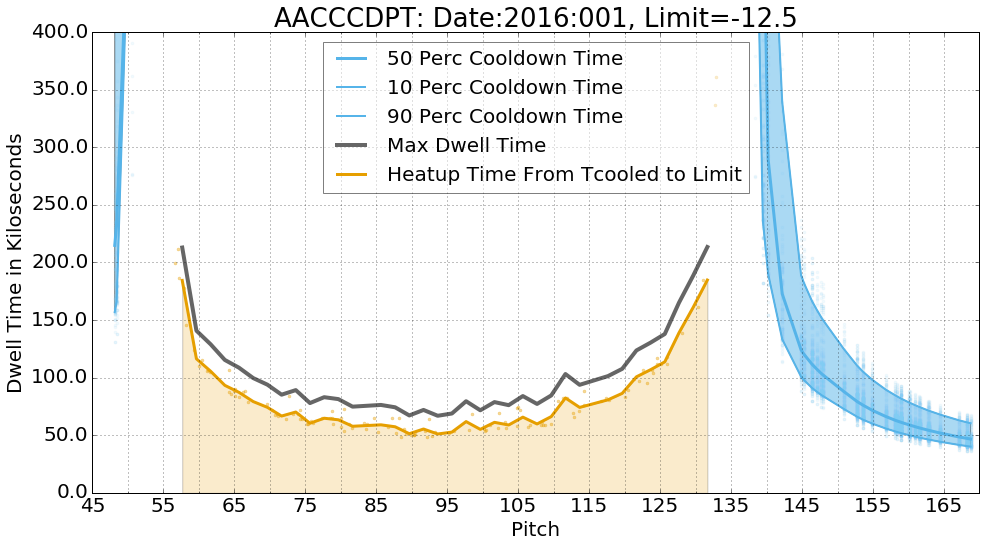

In [104]:
plot_cooldown(cool_constraints, coolstats, hotstats, 'aca', 'aacccdpt', '-12.5')